In [1]:
from pkasolver import data
from pkasolver import chemistry
from pkasolver import model
from pkasolver import analysis
from pkasolver import constants as c
import pickle
from captum.attr import IntegratedGradients
import numpy as np

In [2]:
#SDFs to dict of preprocessed DataFrames
path = "../data/Baltruschat/"
sdf_training = "combined_training_datasets_unique.sdf"
sdf_novartis = "novartis_cleaned_mono_unique_notraindata.sdf"
sdf_AvLiLuMoVe = "AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf"

datasets = {
    "Training": path+sdf_training,
    "Novartis": path+sdf_novartis,
    "AvLiLuMoVe": path+sdf_AvLiLuMoVe,
}

data.preprocess_all(datasets, title='pd_all_datasets')

In [3]:
#Hyperparameters
node_features = [
    'atomic_number',
    'formal_charge',
    'chiral_tag',
    'hybridization',
    'explicit_Hs_number',
    'aromatic_tag',
    'total_valence',
    'total_degree',
    'marvin_atom'
]

edge_features = [
    'bond_type', 
    'is_conjugated'
]

train_test_split = 0.8
batch_size = 32
learning_rate=0.001
num_epochs = 200
device="cpu"
checkpoint_path = 'modelsaves/1#/'
paired_model = False

In [4]:
# Load dict of DataFrames
with open('data/pandas_df/pd_all_datasets.pkl', 'rb') as pickle_file:
    pd_dataset = pickle.load(pickle_file)
# make pyG Dataset form 'Training'- Dataset    
dataset = data.make_pyg_dataset(pd_dataset['Training'], node_features, edge_features, paired=paired_model)
# Split dataset
train_data, test_data = model.pyg_split(dataset, train_test_split)
# Make loaders
train_loader = model.dataset_to_dataloader(train_data, batch_size)
test_loader = model.dataset_to_dataloader(test_data, batch_size)
#print(dataset[0].ID,dataset[0], '\n\n' ,dataset[0].x,'\n\n', dataset[0].edge_index, dataset[0].y)

In [5]:
#Model package imports
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import GCNConv
from torch_geometric.nn import NNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import global_add_pool
from torch import optim
    
#Model Class:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(1)

        num_features = dataset[0].num_features
        num_edge_features = dataset[0].num_edge_features


        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, dataset[0].num_node_features* 96))
        self.conv1 = NNConv(dataset[0].num_node_features, 96, nn=nn)
        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, 96* hidden_channels))
        self.conv2 = NNConv(96, hidden_channels, nn=nn)
        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, hidden_channels* hidden_channels))
        self.conv3 = NNConv(hidden_channels, hidden_channels, nn=nn)
        self.conv4 = NNConv(hidden_channels, hidden_channels, nn=nn)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_attr, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_attr)
        x = x.relu()
        # 2. Readout layer
        x = global_mean_pool(x, batch.to(device=device))  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        #x = x.relu() + 0.000001

        return x

In [6]:
# Create Single model
net = GCN(hidden_channels=32).to(device=device)
print(net)

GCN(
  (conv1): NNConv(9, 96, aggr="add", nn=Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=864, bias=True)
  ))
  (conv2): NNConv(96, 32, aggr="add", nn=Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3072, bias=True)
  ))
  (conv3): NNConv(32, 32, aggr="add", nn=Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1024, bias=True)
  ))
  (conv4): NNConv(32, 32, aggr="add", nn=Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1024, bias=True)
  ))
  (lin): Linear(in_features=32, out_features=1, bias=True)
)


In [7]:
#Single Model
params = list(net.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)
criterion = torch.nn.MSELoss()
criterion_v = torch.nn.L1Loss() # that's the MAE Loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

def train(loader):
    net.train()
    for data in loader:  # Iterate in batches over the training dataset. 
        out = net(data.x, data.edge_attr, data.edge_index, data.x_batch)  # Perform a single forward pass.
        loss = criterion(out.flatten(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad() # Clear gradients.
        
def test(loader):
    net.eval()
    loss = torch.Tensor([0]).to(device=device)
    for data in loader:  # Iterate in batches over the training dataset.
        out = net(data.x, data.edge_attr, data.edge_index, data.x_batch)  # Perform a single forward pass.
        loss += criterion_v(out.flatten(), data.y)
    return loss/len(loader) # MAE loss of batches can be summed and divided by the number of batches

# Save first checkpoint
checkpoint = {
    'epoch': 0,
    'model_state': net,
    'optimizer_state': optimizer,
    'training_data': [train_data[i].ID for i in range(len(train_data))],
    'test_data': [test_data[i].ID for i in range(len(test_data))],
    'node_features': node_features,
    'edge_features': edge_features,
    'progress':'',
    'paired_model':paired_model
}
torch.save(checkpoint,f'{checkpoint_path}checkpoint_epoch_0.pth')

In [8]:
#load checkpoint 
checkpoint = torch.load('modelsaves/1#/checkpoint_epoch_0.pth')
train_data =data.load_data(dataset, checkpoint['training_data'])
test_data =data.load_data(dataset, checkpoint['test_data'])

In [9]:
for epoch in range(checkpoint['epoch'], num_epochs):
    if epoch != 0: 
        train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 10 == 0:
        update = f'Epoch: {epoch:03d}, Train MAE: {train_acc.item():.4f}, Test MAE: {test_acc.item():.4f}'
        print(update)
    if epoch % 100 ==0:
        checkpoint = model.update_checkpoint(checkpoint, epoch, net, optimizer, update, f'{checkpoint_path}checkpoint_epoch_{epoch}.pth')
        #torch.save(checkpoint,f'{checkpoint_path}checkpoint_epoch{epoch}')

Epoch: 000, Train MAE: 10.3370, Test MAE: 10.2368
Epoch: 010, Train MAE: 1.6283, Test MAE: 1.6969


KeyboardInterrupt: 

In [10]:
print(checkpoint['progress'])

Epoch: 000, Train MAE: 10.3370, Test MAE: 10.2368



1 of 50
6 of 50
11 of 50
16 of 50
21 of 50
26 of 50
31 of 50
36 of 50
41 of 50
46 of 50
Average Feature Importances
atomic_number :  0.131
formal_charge :  -0.019
chiral_tag :  -0.003
hybridization :  0.027
explicit_Hs_number :  0.012
aromatic_tag :  -0.001
total_valence :  0.166
total_degree :  0.079
marvin_atom :  0.028
bond_type :  -0.169
is_conjugated :  0.097


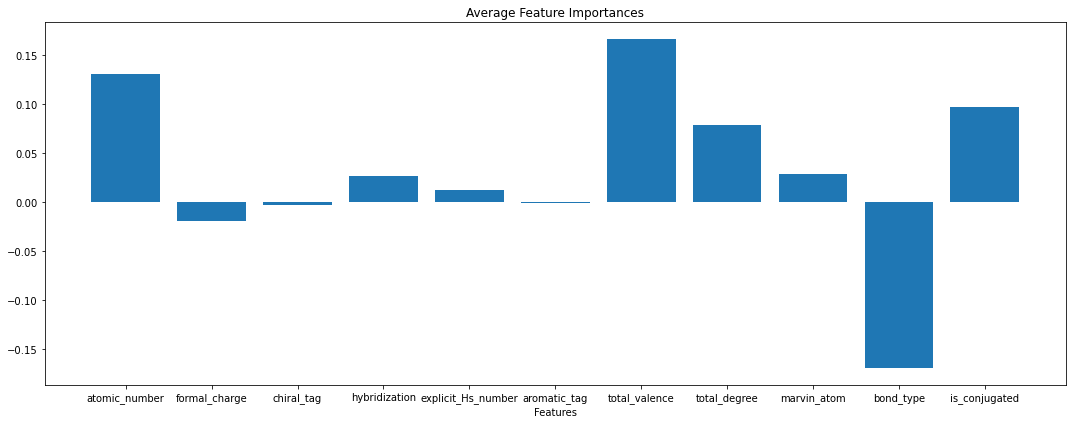

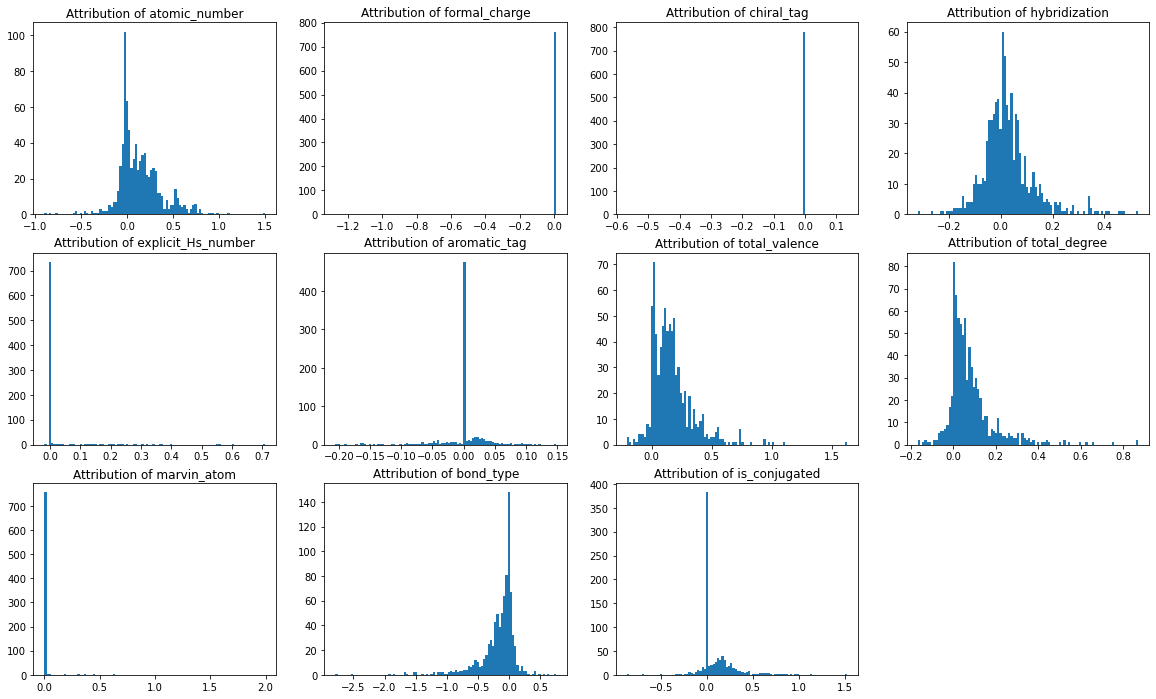

In [11]:
ig = IntegratedGradients(net)
attr_n, attr_e  = analysis.calc_importances(ig, dataset, 50)
analysis.visualize_importances(node_features, edge_features, np.mean(attr_n, axis=0), np.mean(attr_e, axis=0))
analysis.show_importances_distribution(node_features, attr_n, edge_features, attr_e)